# 1. Preprocessing

## 1.1 Loading libraries and dataset

In [1]:
import json
import os
from pathlib import Path
from os.path import join
from os import listdir

import kagglehub
import pandas as pd
import numpy as np
from tqdm import tqdm

import src.utils as u
import src.constants as c
import src.balanced.dataset_processing as bdp



In [2]:
cwd = Path().absolute().parent.parent

kagglehub.auth.whoami()
kagglepath = kagglehub.dataset_download('arct22/codebrim-balanced')

org_imgs_merged = join(cwd, 'datasets', 'org', 'images')
pad_images = join(cwd, 'datasets', 'pad', 'images')
pad_labels = join(cwd, 'datasets', 'pad', 'labels')

Kaggle credentials successfully validated.


In [3]:
kagglepath

'C:\\Users\\Hubert\\.cache\\kagglehub\\datasets\\arct22\\codebrim-balanced\\versions\\2'

In [4]:
def list_all_folders(path):
    base_path = Path(path)
    return [str(p.relative_to(base_path)) for p in base_path.rglob("*") if p.is_dir()]


list_all_folders(kagglepath)

['metadata',
 'test',
 'train',
 'val',
 'test\\background',
 'test\\defects',
 'train\\background',
 'train\\defects',
 'val\\background',
 'val\\defects']

We can see that dataset subdirectories train, test and val have separate subfolders for backgrounds and defects. We will merge them, since YOLO will be not able to recognize such folder structure.

In [5]:
# copiedpaths = bdp.copy_bg_and_defects(kagglepath, org_imgs_merged)

In [6]:
bg_xml = u.xml_to_dict(join(kagglepath, 'metadata', 'background.xml'))['Annotation']['Defect']
defects_xml = u.xml_to_dict(join(kagglepath, 'metadata', 'defects.xml'))['Annotation']['Defect']

org_bg_df = pd.DataFrame(bg_xml)
org_defects_df = pd.DataFrame(defects_xml)
org_df = pd.concat([org_bg_df, org_defects_df])

org_df = org_df.rename(columns={'@name': c.IMG})
org_df[c.defect_names] = org_df[c.defect_names].astype(np.uint8)
org_df

,img,Background,Crack,Spallation,Efflorescence,ExposedBars,CorrosionStain
0,image_0000001_crop_0000001.png,1,0,0,0,0,0
1,image_0000001_crop_0000002.png,1,0,0,0,0,0
2,image_0000001_crop_0000003.png,1,0,0,0,0,0
3,image_0000001_crop_0000004.png,1,0,0,0,0,0
4,image_0000001_crop_0000005.png,1,0,0,0,0,0
...,...,...,...,...,...,...,...
7967,image_0001599_crop_0000005_copy00.png,0,0,1,0,1,1
7968,image_0001599_crop_0000006_copy00.png,0,0,1,0,1,1
7969,image_0001599_crop_0000008_copy00.png,0,0,0,1,0,1
7970,image_0001599_crop_0000008_copy01.png,0,0,0,1,0,1


## 1.2 Data Exploration

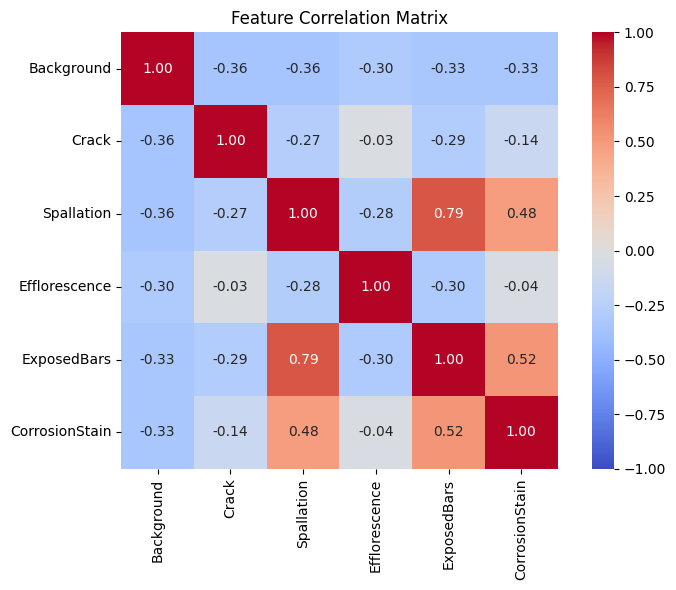


Strongest Correlations:
Spallation - ExposedBars: 0.787
ExposedBars - CorrosionStain: 0.523
Spallation - CorrosionStain: 0.478
Background - Spallation: -0.359
Background - Crack: -0.357


In [7]:
bdp.plot_corr_matrix(org_df, (8, 6))

The correlation matrix reveals logical relationships between defect classes- for ex. there is no corrosion stains without exposed reinforcement bars, and bars can be only exposed, if conrete is spalted. This indicates, that data collection methodology was collected correctly, showing that images were correctly annotated.

We can see that maximal correlation for between features exists for pair Spallation - ExposedBars- 0.787. In addition, we can also see high correlation between those two defect types and CorrosionStain (0.478 and 0.523, respectivelly). Again,

We will merge these three columns to reduce number of classes that model will have to detect.

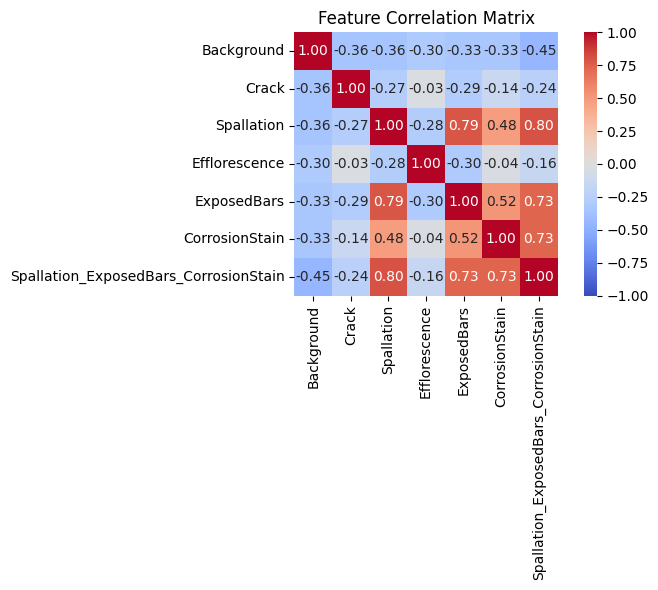


Strongest Correlations:
Spallation - Spallation_ExposedBars_CorrosionStain: 0.800
Spallation - ExposedBars: 0.787
ExposedBars - Spallation_ExposedBars_CorrosionStain: 0.733
CorrosionStain - Spallation_ExposedBars_CorrosionStain: 0.731
ExposedBars - CorrosionStain: 0.523


In [8]:
merged_cols = [c.SPALLATION, c.EXPOSEDBARS, c.CORROSIONSTAIN]

merged_col_name = "_".join(col for col in merged_cols)
org_df[merged_col_name] = (org_df[merged_cols[0]] | org_df[merged_cols[1]] | org_df[merged_cols[2]])
bdp.plot_corr_matrix(org_df, (8, 6))

Our new feature strongly correlates with original features, what indicates that it is able to correctly capture relationships between these defect types. Thus, we can safely drop original columns.

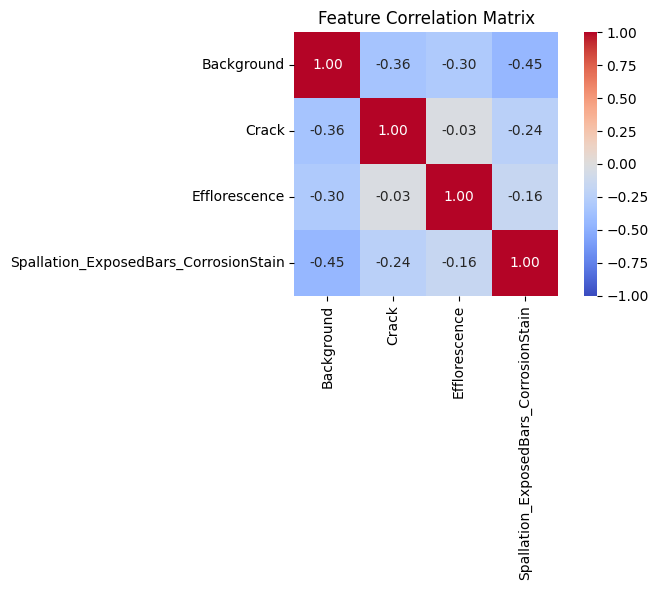


Strongest Correlations:
Background - Spallation_ExposedBars_CorrosionStain: -0.449
Background - Crack: -0.357
Background - Efflorescence: -0.303
Crack - Spallation_ExposedBars_CorrosionStain: -0.240
Efflorescence - Spallation_ExposedBars_CorrosionStain: -0.157


In [9]:
org_df = org_df.drop(merged_cols, axis=1)
bdp.plot_corr_matrix(org_df, (8, 6))

By applying dimensionality reduction, we were able to reduce amount of possible combinations from 33 to 9.

Let's see now how many times each combination of defects appears in dataset.

In [10]:
numerical_cols = org_df.select_dtypes(include=np.number).columns.tolist()

combination_counts = org_df.groupby(numerical_cols).size().reset_index(name='count')

# Sort by count in descending order
combination_counts = combination_counts.sort_values('count', ascending=False)
combination_counts

,Background,Crack,Efflorescence,Spallation_ExposedBars_CorrosionStain,count
1,0,0,0,1,3149
8,1,0,0,0,2490
4,0,1,0,0,2036
2,0,0,1,0,1420
5,0,1,0,1,360
6,0,1,1,0,360
3,0,0,1,1,324
7,0,1,1,1,271
0,0,0,0,0,52


We can see that three is combination [0, 0, 0, 0] which is rarest of all combinations (only 52 times). Since this is undefined type of defect, we will drop rows with these values.

In [11]:
rows_to_drop = ~(org_df[numerical_cols] == [0, 0, 0, 0]).all(axis=1)
org_df_filtered = org_df[rows_to_drop].copy()

Now, we will map a numerical value to each combination.

In [12]:
# First, make sure to get the combinations correctly
combinations = org_df_filtered[numerical_cols].value_counts().index.tolist()

# Print to check what we have
print("Combinations:", combinations)

# Only then create the mapping
mapping = {comb: i for i, comb in enumerate(combinations)}

# Create the new column
org_df_filtered['combination_id'] = org_df_filtered[numerical_cols].apply(tuple, axis=1).map(mapping)

Combinations: [(0, 0, 0, 1), (1, 0, 0, 0), (0, 1, 0, 0), (0, 0, 1, 0), (0, 1, 0, 1), (0, 1, 1, 0), (0, 0, 1, 1), (0, 1, 1, 1)]


In [13]:
org_df_filtered[numerical_cols].sum()

Background                               2490
Crack                                    3027
Efflorescence                            2375
Spallation_ExposedBars_CorrosionStain    4104
dtype: uint64

And map each label to adequate image in train, test, or split folder.

In [14]:
dfs_splited = {
    'train': [],
    'test': [],
    'val': []
}

for split in ['val', 'test', 'train']:
    imgs_splitted = listdir(join(org_imgs_merged, split))
    dfs_splited[split] = org_df_filtered[org_df_filtered['img'].isin(imgs_splitted)]


In [ ]:
yolo_labels_new = {
    'train': {
        'img': [],
        'bbox': []
    },
    'test': {
        'img': [],
        'bbox': []
    },
    'val': {
        'img': [],
        'bbox': []
    }
}

for split in ['val', 'test', 'train']:
    org_dir = join(org_imgs_merged, split)
    output_path = join(pad_images, split)
    os.makedirs(output_path, exist_ok=True)

    print(f'resizing and padding: {split} dataset')
    for img in tqdm(dfs_splited[split]['img']):
        bbox = bdp.resize_and_pad_yolo(image_path=join(org_dir, img),
                                       output_path=join(output_path, img),
                                       target_size=640)

        yolo_labels_new[split][c.IMG].append(img)
        yolo_labels_new[split][c.BBOX].append(bbox)

resizing and padding: val dataset


100%|██████████| 611/611 [01:09<00:00,  8.77it/s]


resizing and padding: test dataset


100%|██████████| 628/628 [01:08<00:00,  9.11it/s]


resizing and padding: train dataset


  8%|▊         | 779/9166 [01:32<18:41,  7.48it/s]

In [23]:
with open(join(cwd, 'datasets', 'pad', 'yolo_labels_new.json'), 'w') as f:
    json.dump(yolo_labels_new, f, indent=4)

In [25]:
yolo_df = {
    'train': '',
    'test': '',
    'val': ''
}

for split in ['train', 'test', 'val']:
    split_df = pd.DataFrame.from_dict(yolo_labels_new[split])
    yolo_df[split] = org_df_filtered.merge(
        split_df,
        on='img',
        how='left'
    )

In [26]:
yolo_df['train']

,img,Background,Crack,Efflorescence,Spallation_ExposedBars_CorrosionStain,combination_id,bbox
0,image_0000001_crop_0000001.png,1,0,0,0,1,"[0.5, 0.5, 1.0, 0.7375]"
1,image_0000001_crop_0000002.png,1,0,0,0,1,"[0.5, 0.5, 0.5125, 1.0]"
2,image_0000001_crop_0000003.png,1,0,0,0,1,"[0.49921875, 0.5, 0.4734375, 1.0]"
3,image_0000001_crop_0000004.png,1,0,0,0,1,"[0.49921875, 0.5, 0.7015625, 1.0]"
4,image_0000001_crop_0000005.png,1,0,0,0,1,"[0.49921875, 0.5, 0.7015625, 1.0]"
...,...,...,...,...,...,...,...
10405,image_0001599_crop_0000005_copy00.png,0,0,0,1,0,"[0.5, 0.5, 0.4, 1.0]"
10406,image_0001599_crop_0000006_copy00.png,0,0,0,1,0,"[0.5, 0.49921875, 1.0, 0.6734375]"
10407,image_0001599_crop_0000008_copy00.png,0,0,1,1,6,"[0.49921875, 0.5, 0.8171875, 1.0]"
10408,image_0001599_crop_0000008_copy01.png,0,0,1,1,6,"[0.49921875, 0.5, 0.8171875, 1.0]"


In [33]:
for split in ['train', 'test', 'val']:
    directory = join(cwd, 'datasets', 'pad', 'labels', split)
    for index, row in yolo_df['test'].iterrows():
        filename = row[c.IMG].split('.')[0] + '.txt'
        print(filename)
        with open(join(cwd, 'datasets', 'pad', 'labels', split, filename), 'w') as f:
            f.write()

image_0000001_crop_0000001.txt
image_0000001_crop_0000002.txt
image_0000001_crop_0000003.txt
image_0000001_crop_0000004.txt
image_0000001_crop_0000005.txt
image_0000002_crop_0000001.txt
image_0000002_crop_0000002.txt
image_0000002_crop_0000003.txt
image_0000002_crop_0000004.txt
image_0000002_crop_0000005.txt
image_0000003_crop_0000001.txt
image_0000003_crop_0000002.txt
image_0000003_crop_0000003.txt
image_0000003_crop_0000004.txt
image_0000003_crop_0000005.txt
image_0000004_crop_0000001.txt
image_0000004_crop_0000002.txt
image_0000004_crop_0000003.txt
image_0000004_crop_0000004.txt
image_0000004_crop_0000005.txt
image_0000006_crop_0000001.txt
image_0000006_crop_0000002.txt
image_0000006_crop_0000003.txt
image_0000006_crop_0000004.txt
image_0000006_crop_0000005.txt
image_0000007_crop_0000001.txt
image_0000007_crop_0000002.txt
image_0000007_crop_0000003.txt
image_0000007_crop_0000004.txt
image_0000007_crop_0000005.txt
image_0000008_crop_0000001.txt
image_0000008_crop_0000002.txt
image_00